## Load Inputs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import cromwell_tools as cwt
from google.cloud import storage
import glob
from collections import defaultdict
from scsequtil.plot import grid
from operator import itemgetter
from sklearn.linear_model import LinearRegression
import numpy as np

In [ ]:
google_project = 'insert_your_project'
cromwell_url = 'your_cromwell_url'

## Configure Cloud Entities

Configure a connection to a locally initiated version of cromwell (version >= 29) and the google project. You will likely have to authenticate independently to enable access to your google storage. 

In [3]:
local_config = {'cromwell_url': cromwell_url}
cromwell = cwt.Cromwell(**local_config)
cromwell.server_is_running()

True

In [4]:
client = storage.Client(project=google_project)

## Set up testing workflows

in the `src/cromwell_tools/test/data/` folder are four WDL files pointing to google storage locations that each contain a different number of fastq reads: 10,000, 100,000, 1,000,000, and 10,000,000. We will use a monitoring script to run each of these workflows, and then calculate the resource usage (memory and disk) of each file throughout each of the run tasks

In [4]:
input_files = glob.glob('src/cromwell_tools/test/data/10x_count_inputs_1e*.json')
wdl = 'src/skylab/10x/count/10x_count.wdl'
options = 'src/cromwell_tools/test/data/options.json'
memory_test_workflows = [cwt.Workflow.from_submission(wdl, i, options, cromwell, wait=True) for i in input_files[1:]]
for workflow in memory_test_workflows:
    workflow.wait_until_complete()

The above function just checks that the runs are in a terminal state. Below we check that each of the runs have *successfully* completed. 

In [8]:
cromwell.query(status=['Succeeded']).json()

{'results': [{'end': '2017-10-04T15:36:49.730-07:00',
   'id': '74e00c0a-ffb8-4e1a-94db-b0169ca7ed42',
   'name': 'count',
   'start': '2017-10-04T14:29:43.624-07:00',
   'status': 'Succeeded'},
  {'end': '2017-10-04T15:43:26.768-07:00',
   'id': '10be2514-9f6b-4e7f-a443-4f342880fc64',
   'name': 'count',
   'start': '2017-10-04T14:34:23.885-07:00',
   'status': 'Succeeded'},
  {'end': '2017-10-04T15:59:53.224-07:00',
   'id': '9fdb2e27-d915-43e9-963e-65b01f0ed9db',
   'name': 'count',
   'start': '2017-10-04T14:34:23.885-07:00',
   'status': 'Succeeded'},
  {'end': '2017-10-04T21:03:33.914-07:00',
   'id': 'c17748ac-4620-45d8-959c-2c6e80bcb400',
   'name': 'count',
   'start': '2017-10-04T14:34:23.885-07:00',
   'status': 'Succeeded'}]}

Parse each of the resource utilization for each task, then display the tasks for the first workflow. 

In [6]:
# get memory utilization
for t in memory_test_workflows:
    t.tasks(retrieve=True)

# display the run tasks
memory_test_workflows[0].tasks(retrieve=False)

{'count.align_reads_main': <cromwell_tools.task.Task at 0x10c2bb828>,
 'count.align_reads_split': <cromwell_tools.task.Task at 0x10c2a57b8>,
 'count.attach_bcs_and_umis_join': <cromwell_tools.task.Task at 0x10c2bba90>,
 'count.attach_bcs_and_umis_main': <cromwell_tools.task.Task at 0x10c2c3ef0>,
 'count.bucket_by_bc_main': <cromwell_tools.task.Task at 0x10c2c36d8>,
 'count.bucket_by_bc_split': <cromwell_tools.task.Task at 0x10c2bb6d8>,
 'count.chunk_reads_join': <cromwell_tools.task.Task at 0x10b1310b8>,
 'count.chunk_reads_main': <cromwell_tools.task.Task at 0x10b1314e0>,
 'count.chunk_reads_split': <cromwell_tools.task.Task at 0x10c2c3978>,
 'count.count_genes_join': <cromwell_tools.task.Task at 0x10c2bb198>,
 'count.count_genes_main': <cromwell_tools.task.Task at 0x10c2c34e0>,
 'count.count_genes_split': <cromwell_tools.task.Task at 0x10c2c3358>,
 'count.extract_reads_join': <cromwell_tools.task.Task at 0x10c2bbfd0>,
 'count.extract_reads_main': <cromwell_tools.task.Task at 0x10c2a5

Now group the tasks across the four experiments so we have a dictionary with four values for each task.

In [7]:
aggregated = defaultdict(list)
for size, w in zip([1e4, 1e5, 1e6, 1e7], memory_test_workflows):
    for task_name, task in w.tasks(retrieve=False).items():
        aggregated[task_name].append([size, task.resource_utilization])

## Memory Usage by Task

Write two scripts to: 

- Calculate the linear equation that describes the relationship between the input data size `x` and the memory used. 
  - Below, we can see that after we fit an intercept (a baseline required amount of memory for a task) most of the tasks are not dependent upon the input size, suggesting that the task is dealing the the data sequentially, rather than loading it into memory. This is good!
- Display the relationship on the same axes, displaying which tasks have the highest memory usage. 

In [73]:
# calculate the memory usage equation (fit linear function)
print('10x Count Memory Usage:')
for task_name, results in sorted(aggregated.items(), key=itemgetter(0)):
    sizes, results = zip(*sorted(results, key=itemgetter(0)))
    usage = [getattr(r, 'max_memory') for r in results]
    
    sizes = np.log(np.array(list(sizes))[:, None])
    usage = np.log(np.array(usage)[:, None])
    lr = LinearRegression()
    lr.fit(sizes, usage)
    print('{task}: {b:.2f} + {m:.2f}*x'.format(task=task_name, b=np.ravel(np.exp(lr.intercept_))[0], m=np.ravel(lr.coef_)[0]))

10x Count Memory Usage:
count.align_reads_main: 1248.17 + 0.03*x
count.align_reads_split: 320.07 + -0.01*x
count.attach_bcs_and_umis_join: 233.52 + 0.11*x
count.attach_bcs_and_umis_main: 113.99 + 0.15*x
count.bucket_by_bc_main: 1.79 + 0.50*x
count.bucket_by_bc_split: 257.90 + 0.01*x
count.chunk_reads_join: 301.89 + -0.00*x
count.chunk_reads_main: 242.57 + 0.02*x
count.chunk_reads_split: 285.28 + 0.00*x
count.count_genes_join: 376.07 + 0.04*x
count.count_genes_main: 114.84 + 0.12*x
count.count_genes_split: 256.65 + 0.01*x
count.extract_reads_join: 496.16 + 0.00*x
count.extract_reads_main: 435.36 + 0.02*x
count.extract_reads_split: 277.94 + -0.00*x
count.filter_barcodes: 347.87 + 0.04*x
count.mark_duplicates_join: 227.55 + 0.02*x
count.mark_duplicates_main: 199.47 + 0.05*x
count.mark_duplicates_split: 268.63 + 0.00*x
count.setup_chunks: 51.50 + 0.10*x
count.sort_AA: 203.44 + 0.03*x
count.sort_AC: 170.64 + 0.05*x
count.sort_AG: 178.86 + 0.04*x
count.sort_AT: 193.15 + 0.04*x
count.sort_CA:

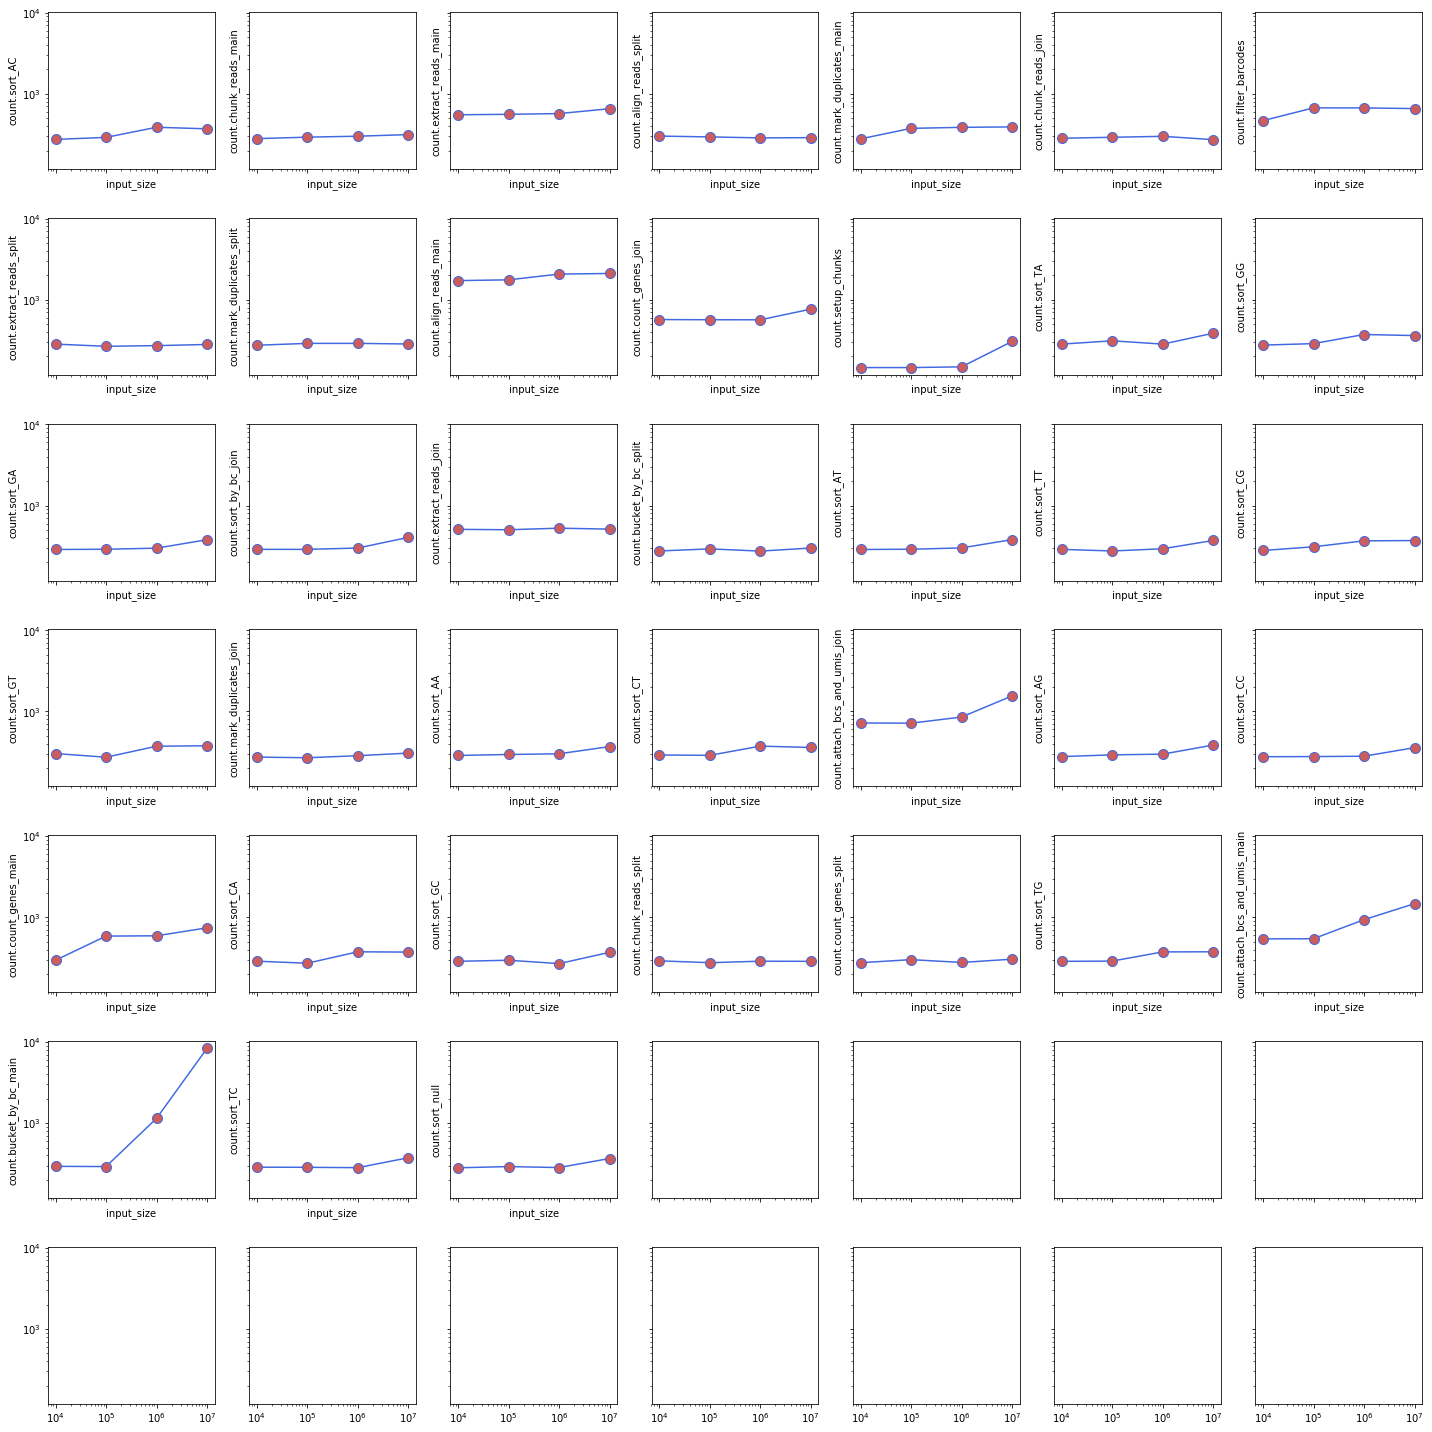

In [110]:
# visualize the results
def plot_attribute(attribute):
    nplots = len(aggregated)
    # make some scatter plots with the amounts vs input sizes
    ag = grid.AxesGrid(nplots, figsize=(20, 20), sharex=True, sharey=True)


    def plot_function(x, y, dependent_var, ax):
        ax.loglog(
            x, y, c='royalblue', marker='o', markersize=10,
            markerfacecolor='indianred')
        ax.set_xlabel('input_size')
        ax.set_ylabel(dependent_var)

    # build argument groups
    args = []
    for task_name, results in sorted(aggregated.items(), key=itemgetter(0)):
        sizes, results = zip(*sorted(results, key=itemgetter(0)))
        usage = [getattr(r, attribute) for r in results]
        args.append((sizes, usage, task_name))

    ag.plot_all(args, plot_function)
    plt.tight_layout()
    return ag

ag = plot_attribute('max_memory')
plt.savefig('memory_utilization.png', dpi=150)

## Disk Usage by Task

Write two scripts to: 

- Calculate the linear equation that describes the relationship between the input data size `x` and the disk used, with the important distinction that this time we don't fit an intercept, as baseline memory utilization should relate to the input quantity. 
  - Below, we can see that each task essentially doubles the input, suggesting that most tasks are writing a duplicate version of the data (whose size is approximately equivalent), presumably containing modifications made by the task. 
- Display the relationship on the same axes, displaying which tasks have the highest disk usage. 

In [9]:
# calculate the disk usage equation (fit linear equation)
print('10x Count Disk Usage:')
for task_name, results in sorted(aggregated.items(), key=itemgetter(0)):
    sizes, results = zip(*sorted(results, key=itemgetter(0)))
    usage = [getattr(r, 'max_disk') for r in results]
    
    sizes = np.log(np.array(list(sizes))[:, None])
    usage = np.log(np.array(usage)[:, None])
    lr = LinearRegression(fit_intercept=False)
    lr.fit(sizes, usage)
    print('{task}: {b:.2f} + {m:.2f}*x'.format(task=task_name, b=np.ravel(np.exp(lr.intercept_))[0], m=np.ravel(lr.coef_)[0]))

10x Count Disk Usage:
count.align_reads_main: 1.00 + 1.10*x
count.align_reads_split: 1.00 + 1.04*x
count.attach_bcs_and_umis_join: 1.00 + 1.08*x
count.attach_bcs_and_umis_main: 1.00 + 1.08*x
count.bucket_by_bc_main: 1.00 + 0.95*x
count.bucket_by_bc_split: 1.00 + 0.95*x
count.chunk_reads_join: 1.00 + 0.83*x
count.chunk_reads_main: 1.00 + 1.01*x
count.chunk_reads_split: 1.00 + 0.83*x
count.count_genes_join: 1.00 + 0.94*x
count.count_genes_main: 1.00 + 1.08*x
count.count_genes_split: 1.00 + 1.08*x
count.extract_reads_join: 1.00 + 1.02*x
count.extract_reads_main: 1.00 + 1.02*x
count.extract_reads_split: 1.00 + 0.83*x
count.filter_barcodes: 1.00 + 0.93*x
count.mark_duplicates_join: 1.00 + 0.95*x
count.mark_duplicates_main: 1.00 + 1.08*x
count.mark_duplicates_split: 1.00 + 0.95*x
count.setup_chunks: 1.00 + 0.94*x
count.sort_AA: 1.00 + 0.87*x
count.sort_AC: 1.00 + 0.88*x
count.sort_AG: 1.00 + 0.88*x
count.sort_AT: 1.00 + 0.86*x
count.sort_CA: 1.00 + 0.88*x
count.sort_CC: 1.00 + 0.87*x
count.s

This is a nice easy conclusion; For the 10x count WDL, the disk request should be approximately the size of the inputs * 2.5 (including 20% additional space to be safe). 

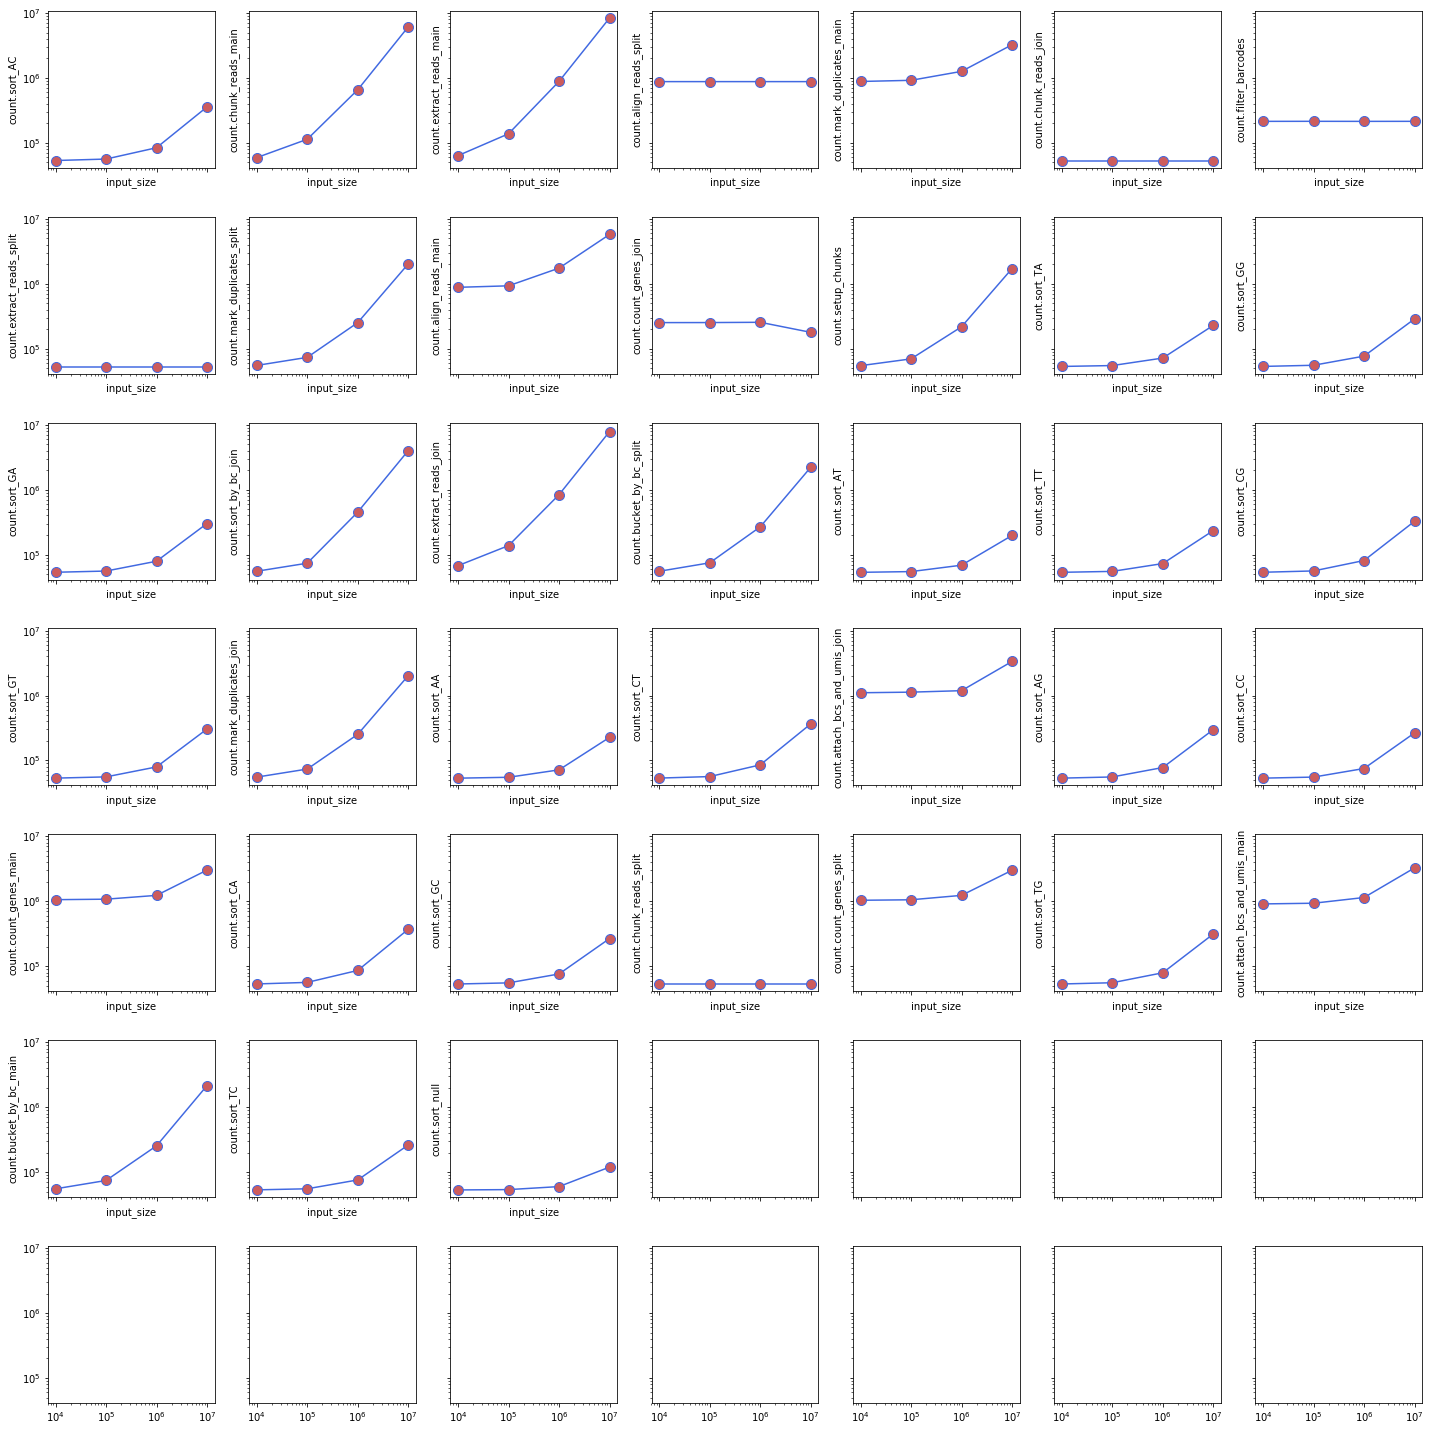

In [109]:
# display disk usage

def plot_attr(attribute):
    nplots = len(aggregated)
    # make some scatter plots with the amounts vs input sizes
    ag = grid.AxesGrid(nplots, figsize=(20, 20), sharex=True, sharey=True)


    def plot_function(x, y, dependent_var, ax):
        ax.loglog(
            x, y, c='royalblue', marker='o', markersize=10,
            markerfacecolor='indianred')
        ax.set_xlabel('input_size')
        ax.set_ylabel(dependent_var)

    # build argument groups
    args = []
    for task_name, results in sorted(aggregated.items(), key=itemgetter(0)):
        sizes, results = zip(*sorted(results, key=itemgetter(0)))
        usage = [getattr(r, attribute) for r in results]
        # usage = [u - min(usage) + 1 for u in usage]
        args.append((sizes, usage, task_name))

    ag.plot_all(args, plot_function)
    return ag

ag = plot_attr('max_disk')
plt.tight_layout()
plt.savefig('disk_utilization.png', dpi=150)